In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
import pickle



In [2]:
spam_sms = pd.read_csv('spam.csv')

In [3]:
spam_sms.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
4507,ham,Not able to do anything.,NaN,NaN,NaN
5436,ham,Mode men or have you left.,NaN,NaN,NaN
952,ham,Beautiful Truth against Gravity.. Read careful...,NaN,NaN,NaN
5771,spam,"""Need cash fast? Get a LOAN approved in minute...",NaN,NaN,NaN
4727,ham,I (Career Tel) have added u as a contact on IN...,NaN,NaN,NaN


**Data Cleaning**


In [4]:
spam_sms.shape

(5801, 5)

In [5]:
spam_sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5801 entries, 0 to 5800
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5801 non-null   object
 1   v2          5801 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 226.7+ KB


In [6]:
spam_sms.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [7]:
spam_sms

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5796,spam,"""Pre-approved LOAN available! Get yours now:"
5797,spam,"""Don't wait! Quick LOAN approval today. Apply ..."
5798,spam,"""Your LOAN is ready to go. Click here to final..."
5799,spam,"""Apply for a low-interest LOAN now! Click here:"


In [8]:
#This v1, v2 column names makes no scence so we will change it to something meaningful.

spam_sms.rename(columns={'v1':'Type of SMS', 'v2': 'SMS Text'}, inplace=True)

In [9]:
spam_sms

,Type of SMS,SMS Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5796,spam,"""Pre-approved LOAN available! Get yours now:"
5797,spam,"""Don't wait! Quick LOAN approval today. Apply ..."
5798,spam,"""Your LOAN is ready to go. Click here to final..."
5799,spam,"""Apply for a low-interest LOAN now! Click here:"


In [10]:
spam_sms.isnull().sum()

Type of SMS    0
SMS Text       0
dtype: int64

In [11]:
#We have some duplicate values which is not idel for developing model, we will terminate them.

spam_sms = spam_sms.drop_duplicates()

In [12]:
spam_sms.duplicated().sum()

0

In [13]:
#As we can see SMS type is in categorical and we need to convert that into numeric values coz most ML algorithms works only with numbers.
#for that we use sklearn library

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

spam_sms.loc[:,'Type of SMS'] = le.fit_transform(spam_sms['Type of SMS'])


In [14]:
spam_sms

,Type of SMS,SMS Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5796,1,"""Pre-approved LOAN available! Get yours now:"
5797,1,"""Don't wait! Quick LOAN approval today. Apply ..."
5798,1,"""Your LOAN is ready to go. Click here to final..."
5799,1,"""Apply for a low-interest LOAN now! Click here:"


**EDA**

In [15]:
#Now there are 5229 rows but doe we know that how many are spam and ham? lets find it out.

spam_sms['Type of SMS'].value_counts()

Type of SMS
0    4516
1     755
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x23d6ee3f5f0>,
 [Text(-0.990496128451091, 0.47845315290360463, 'Ham'),
  Text(0.9904961284510909, -0.47845315290360474, 'Spam')],
 [Text(-0.5402706155187769, 0.2609744470383298, '85.68'),
  Text(0.5402706155187768, -0.26097444703832984, '14.32')])

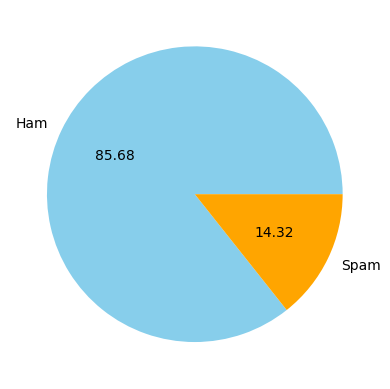

In [16]:
#We can also use visulization lib here for good understanding

plt.pie(spam_sms['Type of SMS'].value_counts(),labels=['Ham','Spam'],autopct='%0.2f', colors=['skyblue','orange'])

In [17]:
#Now we will create a some features to inhance our dataset. we will find out that in a sms text how many words, char, scentences to deeper analysis.
#NOTE: Python's built-in functions are commonly used for character tokenization, and NLTK does not provide a specific function dedicated solely to character tokenization.

spam_sms['Num_Char'] = spam_sms['SMS Text'].apply(len)

C:\Users\Ashwin Kumar\AppData\Local\Temp\ipykernel_21676\2511500328.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam_sms['Num_Char'] = spam_sms['SMS Text'].apply(len)


In [18]:
#for words
spam_sms['Num_Words'] = spam_sms['SMS Text'].apply(lambda x : len(nltk.word_tokenize(x)))

C:\Users\Ashwin Kumar\AppData\Local\Temp\ipykernel_21676\3326062733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam_sms['Num_Words'] = spam_sms['SMS Text'].apply(lambda x : len(nltk.word_tokenize(x)))


In [19]:
#for scentence
spam_sms['Num_Sent'] = spam_sms['SMS Text'].apply(lambda x : len(nltk.sent_tokenize(x)))

C:\Users\Ashwin Kumar\AppData\Local\Temp\ipykernel_21676\355193879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam_sms['Num_Sent'] = spam_sms['SMS Text'].apply(lambda x : len(nltk.sent_tokenize(x)))


In [20]:
spam_sms.describe()

,Num_Char,Num_Words,Num_Sent
count,5271.000000,5271.000000,5271.000000
mean,79.611459,18.547334,1.984064
std,58.197596,13.271690,1.457732
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,2.000000
75%,119.500000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [21]:
spam_sms.head()

,Type of SMS,SMS Text,Num_Char,Num_Words,Num_Sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [22]:
#Ham
spam_sms[spam_sms['Type of SMS'] == 1].describe()

,Num_Char,Num_Words,Num_Sent
count,755.000000,755.000000,755.000000
mean,134.352318,27.062252,2.964238
std,33.920376,7.483853,1.505091
min,13.000000,2.000000,1.000000
25%,126.000000,24.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


In [23]:
#Spam
spam_sms[spam_sms['Type of SMS'] == 0].describe()

,Num_Char,Num_Words,Num_Sent
count,4516.000000,4516.000000,4516.000000
mean,70.459699,17.123782,1.820195
std,56.358868,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


<Axes: xlabel='Num_Char', ylabel='Count'>

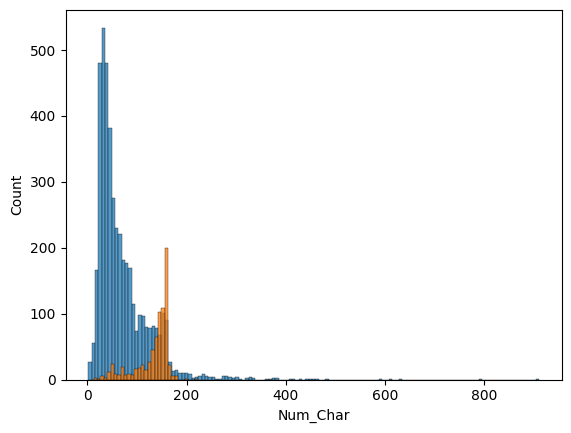

In [24]:
sns.histplot(spam_sms[spam_sms['Type of SMS'] == 0]['Num_Char'])
sns.histplot(spam_sms[spam_sms['Type of SMS'] == 1]['Num_Char'])


<Axes: xlabel='Num_Words', ylabel='Count'>

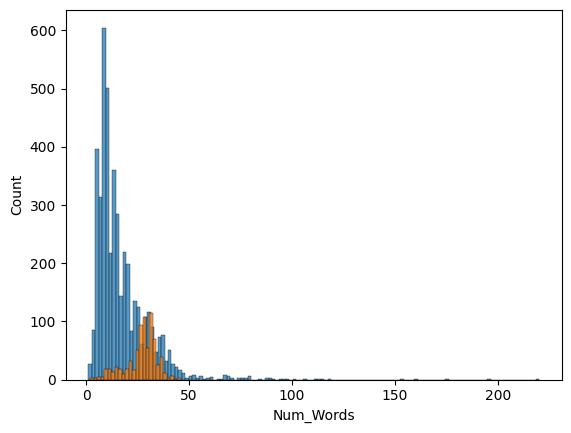

In [25]:
sns.histplot(spam_sms[spam_sms['Type of SMS'] == 0]['Num_Words'])
sns.histplot(spam_sms[spam_sms['Type of SMS'] == 1]['Num_Words'])


<Axes: xlabel='Num_Sent', ylabel='Count'>

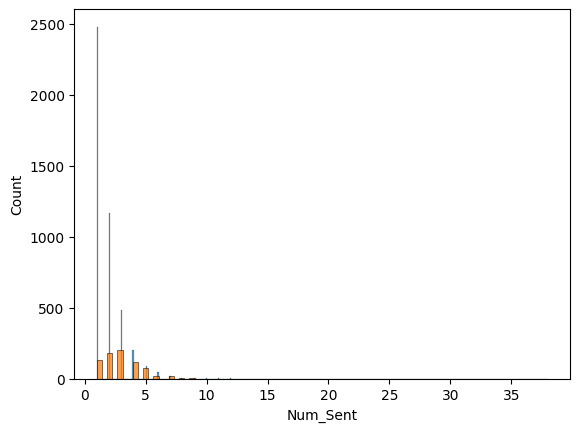

In [26]:
sns.histplot(spam_sms[spam_sms['Type of SMS'] == 0]['Num_Sent'])
sns.histplot(spam_sms[spam_sms['Type of SMS'] == 1]['Num_Sent'])

In [27]:
spam_sms['Type of SMS']=spam_sms['Type of SMS'].astype(dtype='int64')

C:\Users\Ashwin Kumar\AppData\Local\Temp\ipykernel_21676\203481597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam_sms['Type of SMS']=spam_sms['Type of SMS'].astype(dtype='int64')


<Axes: >

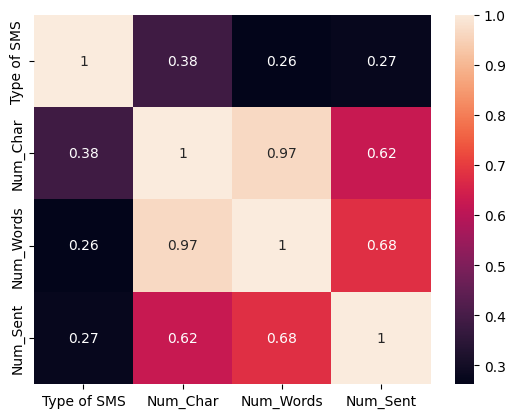

In [28]:
x = spam_sms.select_dtypes(include='int64')
sns.heatmap(x.corr(), annot=True)
#As we can see among num_sent, word and char only num_char have  high positive correlation of 0.43 so we will use Num_char

In [29]:
from wordcloud import WordCloud
wc = WordCloud()

wc_for_spam = wc.generate(spam_sms[spam_sms['Type of SMS'] == 1]['SMS Text'].str.cat(sep=" "))

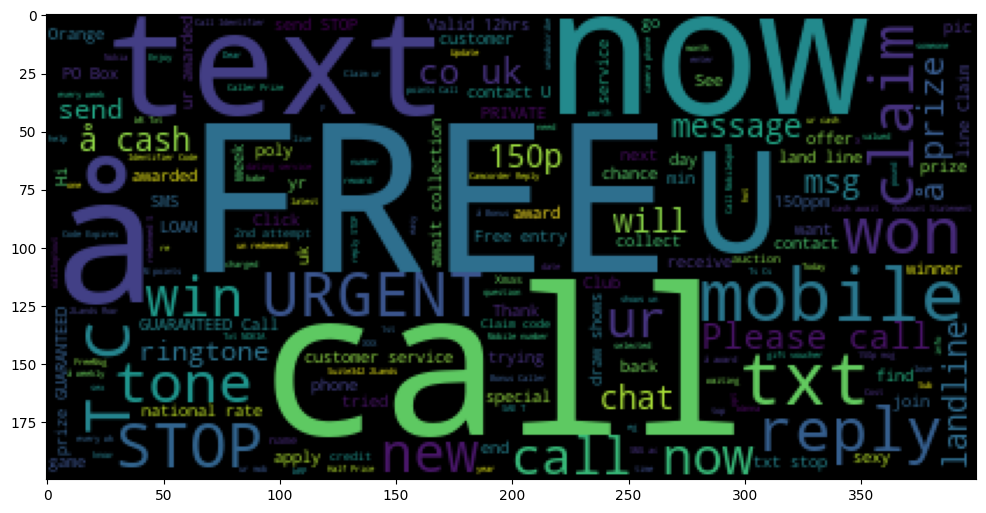

In [30]:
plt.figure(figsize=(12,12))
plt.imshow(wc_for_spam)


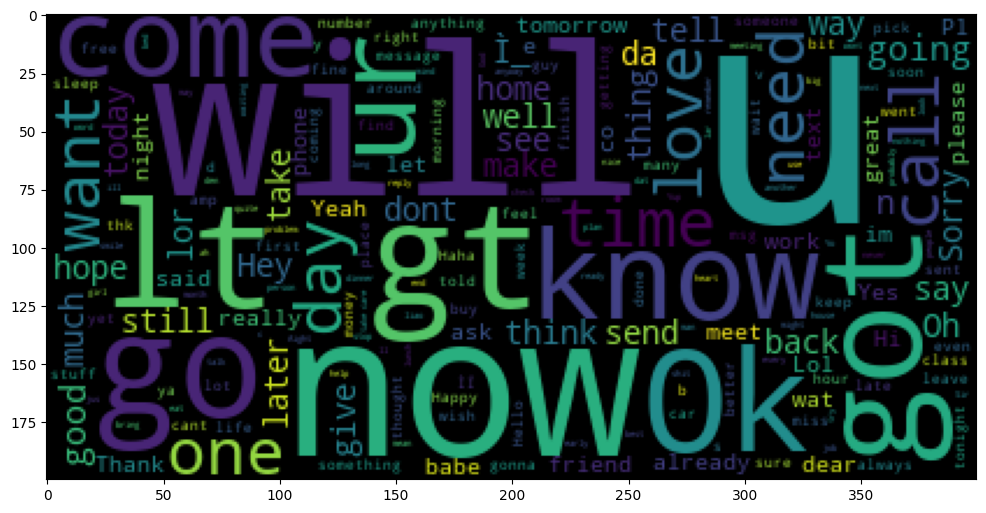

In [31]:
wc_for_ham = wc.generate(spam_sms[spam_sms['Type of SMS'] == 0]['SMS Text'].str.cat(sep=" "))
plt.figure(figsize=(12,12))
plt.imshow(wc_for_ham )


**Data Preprocessing**

1.Lower Case: Converts all characters in the text to lowercase for consistency.

2.Tokenization: Splits text into individual words or tokens.

3.Removing Special Characters: Eliminates non-relevant characters like symbols and punctuation.

4.Removing Stop Words and Punctuation: Removes common words and punctuation that do not add significant meaning.

5.Stemming: Reduces words to their root form to unify different variations.

In [32]:
ps = PorterStemmer()
def transform_text(text):
    # Convert to lower case
    text = text.lower()

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove non-alphanumeric tokens and stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.isalnum() and token not in stop_words]

    # Stem the tokens
    stemmed_tokens = [ps.stem(token) for token in filtered_tokens]

    # Join tokens into a single string
    return " ".join(stemmed_tokens)

print(transform_text('HI HOW huhuhu090{}{} ARE YOU, WHATS YOU 20% IN EXAM? loved Do walking'))


hi huhuhu090 what 20 exam love walk


In [33]:
spam_sms['Transform SMS'] = spam_sms['SMS Text'].apply(transform_text)

C:\Users\Ashwin Kumar\AppData\Local\Temp\ipykernel_21676\1910054509.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam_sms['Transform SMS'] = spam_sms['SMS Text'].apply(transform_text)


In [34]:
spam_sms.head(3)

,Type of SMS,SMS Text,Num_Char,Num_Words,Num_Sent,Transform SMS
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...


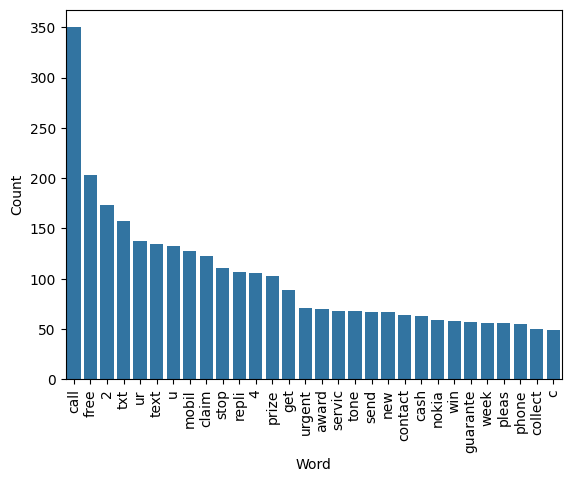

In [35]:
# Extract and process spam messages in a single step
spam_corpus = [word for msg in spam_sms[spam_sms['Type of SMS'] == 1]['Transform SMS'] for word in msg.split()]

# Count the frequency of each word
word_counts = Counter(spam_corpus)

# Get the 30 most common words
common_words = word_counts.most_common(30)

# Convert to DataFrame for visualization
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Plot the results
sns.barplot(x='Word', y='Count', data=df_common_words)
plt.xticks(rotation='vertical')
plt.show()


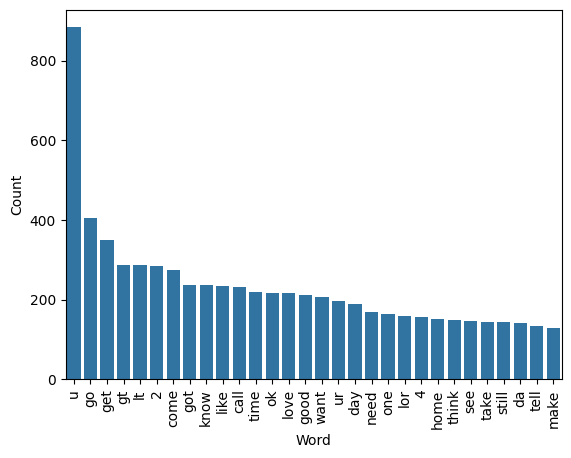

In [36]:

ham_corpus = [word for msg in spam_sms[spam_sms['Type of SMS'] == 0]['Transform SMS'] for word in msg.split()]
word_counts = Counter(ham_corpus)
common_words = word_counts.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

sns.barplot(x='Word', y='Count', data=df_common_words)
plt.xticks(rotation='vertical')
plt.show()


**Model Building**

In [37]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
tfid = TfidfVectorizer(max_features=5000)

x = tfid.fit_transform(spam_sms['Transform SMS']).toarray()
y = spam_sms['Type of SMS'].values

In [38]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=2)

In [39]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
mnb = MultinomialNB()
bnb = BernoulliNB()
gnb = GaussianNB()

In [40]:
mnb.fit(x_train, y_train)
mnb_prediction = mnb.predict(x_test)
print(accuracy_score(mnb_prediction,y_test))
print(confusion_matrix(mnb_prediction,y_test))
print(precision_score(mnb_prediction,y_test))



0.9658767772511848
[[892  35]
 [  1 127]]
0.7839506172839507


In [44]:
bnb.fit(x_train, y_train)
bnb_prediction = bnb.predict(x_test)
print(accuracy_score(bnb_prediction,y_test))
print(confusion_matrix(bnb_prediction,y_test))
print(precision_score(bnb_prediction,y_test))


0.9649289099526066
[[891  35]
 [  2 127]]
0.7839506172839507


In [42]:
gnb.fit(x_train, y_train)
gnb_prediction = gnb.predict(x_test)
print(accuracy_score(gnb_prediction,y_test))
print(confusion_matrix(gnb_prediction,y_test))
print(precision_score(gnb_prediction,y_test))

0.8635071090047394
[[773  24]
 [120 138]]
0.8518518518518519


In [43]:
pickle.dump(tfid, open('vector.pkl', 'wb'))
pickle.dump(bnb, open('model.pkl', 'wb'))